In [2]:
import numpy
import scipy
import pandas
x = pandas.read_csv('train.csv',index_col='id')
y = x['loss'].values
x = x.drop(columns=['loss'])
xTest = pandas.read_csv('test.csv',index_col='id')

Xcont = x.drop(columns=[col for col in x.columns if col.startswith('cat')])
Xcat = x.drop(columns=[col for col in x.columns if col.startswith('cont')])
Xcombined = pandas.concat((x,xTest))
XcombinedDummies = pandas.get_dummies(Xcombined,drop_first=True,columns = [col for col in x.columns if col.startswith('cat')])
X = XcombinedDummies.iloc[:x.shape[0],:]
Xtest = XcombinedDummies.iloc[x.shape[0]:,:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [5]:
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import numpy

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time, numpy

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LassoCV,LassoLarsCV, SGDRegressor, ElasticNetCV
from sklearn.feature_selection import SelectFromModel

def TestEstimator(name, estimator, X_train, y_train, X_test, y_test, tf = False):
    t=time.time()
    if tf:
        y_train_ = numpy.log1p(y_train)
    else:
        y_train_ = y_train
        
    estimator.fit(X_train, y_train_)
    trainTime = time.time()-t
    t = time.time()
    
    y_pred = estimator.predict(X_test)
    if tf:
        y_pred = numpy.expm1(y_pred)
    predictTime = time.time()-t
    
    y_train_pred = estimator.predict(X_train)
    if tf:
        y_train_pred = numpy.expm1(y_train_pred)
    
    error = numpy.sum(numpy.abs(y_pred - y_test)) / len(y_test)
    error_train = numpy.sum(numpy.abs(y_train_pred - y_train)) / len(y_train)
    #print(time.ctime(),name,error,trainTime,predictTime)
    return error_train, error #a difference here indicates divergence

def ExtractFeatures(estimator):
    model = SelectFromModel(estimator, prefit=True)
    return model



In [35]:
#set up estimators:

ridge = RidgeCV()
lin = LinearRegression()
lasso = Lasso()
lassoCV = LassoCV()
lassoLarsCV = LassoLarsCV()
elastic = ElasticNetCV()

#trees
ef = ExtraTreesRegressor(n_estimators=130, n_jobs=-1)
rf =  RandomForestRegressor(n_estimators=130, n_jobs=-1)


sgd = SGDRegressor(loss='huber', penalty='elasticnet',tol = 1e-3,max_iter= 1000)

print ('lasso-lars-cv:  %.2f %.2f'%TestEstimator('lassoLarsCV',lassoLarsCV, X_train, y_train, X_test, y_test, tf=True))

featureReducer = ExtractFeatures(lassoLarsCV)
svd = decomposition.TruncatedSVD(n_components=400)
svd.fit(X_train.values.astype('float32'))
featureReducer2 = svd

X_train_ = featureReducer.transform(X_train)
X_test_ = featureReducer.transform(X_test)
X_train__ = featureReducer2.transform(X_train)
X_test__ = featureReducer2.transform(X_test)
print ('lasso-lars-cv-r2:  %.2f %.2f'%TestEstimator('lassoLarsCV',lassoLarsCV, X_train__, y_train, X_test__, y_test, tf=True))
print ('lasso-full:  %.2f %.2f'%TestEstimator('lasso-full',lasso, X_train, y_train, X_test, y_test, tf=True))
print ('lasso-cv:  %.2f %.2f'%TestEstimator('lassoCV',lassoCV, X_train, y_train, X_test, y_test, tf=True))

print ("elastic-full:     %.2f %.2f"% TestEstimator('elastic',elastic, X_train, y_train, X_test, y_test, tf=True))
print ("elastic-reduced:  %.2f %.2f"% TestEstimator('elastic',elastic, X_train_, y_train, X_test_, y_test, tf=True))
print ("elastic-reduced2: %.2f %.2f"% TestEstimator('elastic',elastic, X_train__, y_train, X_test__, y_test, tf=True))

print ("lin-reduced:      %.2f %.2f"% TestEstimator('lin',lin, X_train_, y_train, X_test_, y_test, tf=True))
print ("lin-reduced2:     %.2f %.2f"% TestEstimator('lin',lin, X_train__, y_train, X_test__, y_test, tf=True))
print ("ridge-full:       %.2f %.2f"% TestEstimator('ridge',ridge, X_train, y_train, X_test, y_test, tf=True))
print ("ridge-reduced:    %.2f %.2f"% TestEstimator('ridge',ridge, X_train_, y_train, X_test_, y_test, tf=True))
print ("ridge-reduced2:   %.2f %.2f"% TestEstimator('ridge',ridge, X_train__, y_train, X_test__, y_test, tf=True))
print ("ridge-full", TestEstimator('ridge',ridge, X_train, y_train, X_test, y_test, tf=True))
print ("ridge-reduced", TestEstimator('ridge',ridge, X_train_, y_train, X_test_, y_test, tf=True))

gb = GradientBoostingRegressor(n_estimators=600, loss='huber')
print ("sgd:              %.2f %.2f"% TestEstimator('sgd',sgd, X_train, y_train, X_test, y_test, tf=True))
print ("sgd-reduced:      %.2f %.2f"% TestEstimator('sgd',sgd, X_train_, y_train, X_test_, y_test, tf=True))
print ("sgd-reduced2:     %.2f %.2f"% TestEstimator('sgd',sgd, X_train__, y_train, X_test__, y_test, tf=True))

print ("gb-reduced:       %.2f %.2f"% TestEstimator('gb',gb, X_train_, y_train, X_test_, y_test, tf=True))
print ("gb-reduced2:      %.2f %.2f"% TestEstimator('gb',gb, X_train__, y_train, X_test__, y_test, tf=True))
print ("gb:               %.2f %.2f"% TestEstimator('gb',gb, X_train, y_train, X_test, y_test, tf=True))
#print (ExtractFeatures(lasso,100))
    

gb:               1158.63 1172.11


In [ ]:
import tensorflow, time
import os
import numpy
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
#from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
import keras.callbacks
from keras import optimizers
from keras import regularizers
from keras.constraints import maxnorm
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split

def ContColumns(X):
    contColumns = [c for c in X.columns if c.startswith('cont')]
    return X[contColumns]

def CatColumns(X):
    catColumns = [c for c in X.columns if c.startswith('cat')]
    return X[catColumns]

def PCACont(X, components =6):
    pcaIn = ContColumns(X)
    ret = PCA(n_components = components).fit_transform(pcaIn)
    #print(X.columns)
    r = X.drop(columns=pcaIn.columns)
    for i in range(components):
        r['pca%d'%(i+1)]=ret[:,i]
    #print (r.columns)
    return r

def SelectCategorical(X,thresh=0.05):
    kbIn = CatColumns(X)
    kb = VarianceThreshold(thresh)
    ret = kb.fit_transform(kbIn)
    r = X.drop(columns=kbIn.columns)
    for i in range(ret.shape[1]):
        r["cat%d"%(i+1)] = ret[:,i]
    return r


class PrepareData:
    def __init__(self, pcaCount, catK):
        self.catK = catK
        self.pcaCount = pcaCount
        
    def fit(self, X, y):
        pcaIn = ContColumns(X)
        self.pca = PCA(n_components = self.pcaCount)
        self.pca.fit(pcaIn)
        self.kbest = SelectKBest(score_func = f_regression, k = self.catK)
        kbIn = CatColumns(X)
        yIn = numpy.log1p(y)
        self.kbest.fit(kbIn, yIn)
    def transform(self, X):
        pcaIn = ContColumns(X)
        kbIn = CatColumns(X)
        r1 = self.kbest.transform(kbIn)
        r2 = self.pca.transform(pcaIn)
        return numpy.c_[r1,r2]
    
EPOCHS = 100
class CustomMLPRegressor:
    """provide a similar interface to the sklearn regressors"""
    def LoadFromFile(self, filename):
        self.model = keras.models.load_model(filename)
        
    def __init__(self, nodes, earlyStopping, dropout):
      
        if type(nodes) is int:
            nodes = (nodes,)
        self.nodes = nodes
        self.dropout = dropout
        self.earlyStopping = earlyStopping
        
    def fit(self, X, y):
        #print (X,y)
        inputDim = X.shape[1]
        model = Sequential()
        self.model = model
        for i, nodeCount in enumerate(self.nodes):
            if i == 0:
                if len(self.nodes) == 1:
                    self.model.add(Dense(nodeCount, input_dim = inputDim, activation='relu'))
                else:
                    self.model.add(Dense(nodeCount, input_dim = inputDim, activation='relu', kernel_constraint = maxnorm(3)))
                    if self.dropout:
                        model.add(Dropout(self.dropout))
            else:
                if len(self.nodes) > i+1:
                    self.model.add(Dense(nodeCount,  activation='relu', kernel_constraint = maxnorm(3)))
                    if self.dropout:
                        model.add(Dropout(self.dropout))
                else:
                    self.model.add(Dense(nodeCount,  activation='relu'))
        model.add(Dense(1))
        opt = optimizers.Nadam()
        model.compile(loss='mae', optimizer=opt)
        #self.model = model
        
        callback_list = []
        filepath="weights-best.hdf5"
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        callback_list.append(checkpoint)
       
        callback_list.append(keras.callbacks.EarlyStopping(min_delta=self.earlyStopping, patience=5,verbose=0))
        history=model.fit(X.values.astype('float32'), y.astype('float32'), 
              epochs=EPOCHS, batch_size=1000,
              verbose=2,validation_split=0.2,callbacks=callback_list)
        bestModel = keras.models.load_model('weights-best.hdf5')
        self.history = history
        self.model =bestModel
        return self
    def predict(self, X):
        #print ('predicting')
        ret =  self.model.predict(X.astype('float32'))
        #print (ret.shape)
        return ret.flatten()
def TestMLP(mlp):
    e_train, e_test = TestEstimator('mlp',mlp, X_train, y_train, X_test, y_test, tf=False)
    print("mlp-%s-%.2f: %.2f %.2f"%(mlp.nodes,mlp.dropout,e_train, e_test))
    try:
        os.rename('weights-best.hdf5','weights-best-%.2f-%.2f-%s.hdf5'%(e_test,mlp.dropout,mlp.nodes))
    except FileExistsError:
        pass
    return e_train, e_test
#the following code was used to populate a results list.  
# The lowest result for nodes/dropout pair was used to represent that point on the dataplot.
for i in range(2):
    nodes = 425+i*75
    for j in range(3):
        dropout =0.2+j*0.05
        mlp = CustomMLPRegressor((nodes,50,10),0.0,dropout)
        e_train, e = TestMLP(mlp)
        results.append([nodes,dropout,e_train, e])
        if e < bestE:
            bestE = e
            bestMLP = mlp

#print ('mlp:  %.2f %.2f'%TestEstimator('mlp',mlp, X_train, y_train, X_test, y_test, tf=True))
#print ('mlp:  %.2f %.2f'%TestEstimator('mlp',mlp, X_train, y_train, X_test, y_test, tf=False))

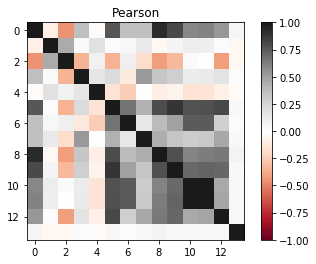

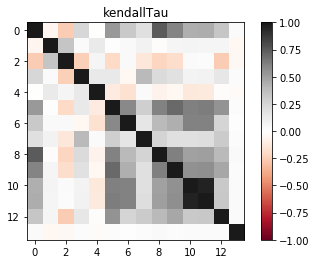

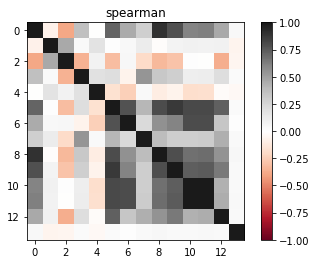

In [22]:
import scipy.stats
import numpy
import matplotlib.pyplot
def Compare(statFunc):
    ret = numpy.zeros((14,14))
    for i in range(14):
        colI = X[X.columns[i]]
        for j in range(14):
            colJ = X[X.columns[j]]

            if (i == j):
                ret[i,j] = 1
            else:
                ret[i,j] = statFunc(colI, colJ)[0]
    return ret
pearson = Compare(scipy.stats.pearsonr)
kendallTau = Compare(scipy.stats.kendalltau)
spearman = Compare(scipy.stats.spearmanr)
matplotlib.pyplot.imshow(pearson, interpolation='nearest', cmap='RdGy',vmin=-1, vmax=1)
matplotlib.pyplot.title('Pearson')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(kendallTau, interpolation='nearest', cmap='RdGy',vmin=-1, vmax=1)
matplotlib.pyplot.title('kendallTau')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(spearman, interpolation='nearest', cmap='RdGy',vmin=-1, vmax=1)
matplotlib.pyplot.title('spearman')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

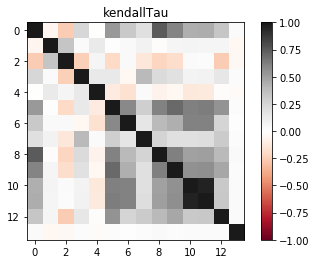

In [17]:
import seaborn as sns


In [37]:
def CreateCSV(filename, estimator, X_test, tf=False):
    y_test =estimator.predict(X_test)
    ofile =open(filename,"w")
    ofile.write("id,loss\n")
    if tf:
        y_test = numpy.expm1(y_test)

    for ix,yval in zip(X_test.index, y_test):
        ofile.write("%d,%.3f\n"%(ix,yval))
    ofile.close()
CreateCSV('test_submission4.csv',gb,Xtest,True)
